### In this Lab, we’ll understand the audio preprocessing pipeline. In the first section we will explore different ways to represent/visualize audio signals. In the second section, we will define our KWS model and run inference on the speech commands dataset. Finally, in the last section of the tutorial, we will test the model on a few audio samples!

# 1. Spectrograms and MFCCs



### Install required Packages

We install the following packages -


1. ffmpeg-python - Python binding for ffmpeg (a free and open-source multimedia processing project). You can read more about it [here](https://ffmpeg.org/about.html).
2. tensorflow-io - provides additional Dataset, streaming, and file system extensions.
3. python_speech_features - provides common speech features including MFCCs.
4. Librosa - a python package for music and audio analysis.


In [ ]:
!pip install ffmpeg-python        # &> shell command to hide output
!pip install tensorflow-io
!pip install python_speech_features
!pip install librosa
print("Packages Installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=b2e15b91cc12ac1123f48a54ca721ad4918a741197fd9f32c83b6287fc31acac
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Packages Installed


### Import everything we will need



1.   [IPython](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html) - Public API for display tools in IPython.
2.    from [google.colab.output](https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=MprPsZJa3AQF) import eval_js - Evaluate a Javascript expression from Python
3. [base64](https://docs.python.org/3/library/base64.html) - provides functions for encoding binary data to printable ASCII characters and decoding such encodings back to binary data.
4. [scipy.io.wavfile](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) - Open a WAV file and returns the sample rate and data.
5. [pickle](https://docs.python.org/3/library/pickle.html) - module for serializing and de-serializing a Python object structure
6. [librosa](https://librosa.org/doc/latest/index.html) - python package for music and audio analysis



In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm
import pickle
import librosa
print("Packages Imported")

Packages Imported


### Define the audio importing function.

The cell below defines an audio recorder that allows us to record audio from our laptop's microphone.



In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))      # returns sample rate, data from wav file

  return audio, sr

print("Chrome Audio Recorder Defined")

Chrome Audio Recorder Defined


In [ ]:
# !rm -rf "/content/dataset"
# !rm -rf "/content/extract_loudest_section"
# !rm -rf "/content/logs"
# !rm -rf "/content/models"
# !rm -rf "/content/sample_data"
# !rm -rf "/content/tensorflow"
# !rm -rf "/content/train"
# !rm -rf "/content/trimmed"

# !rm -rf "/content/tensorflow-2.4.1"

### Load in the Audio Samples [Optional]
###**[A] Record your own audio samples!**

In the below cells, we can record our own audio samples!

After you run each cell wait for the stop button to appear then start recording and then press the button to stop the recording once you have said the word!

In [ ]:
audio_1, sr_1 = get_audio()
print("DONE")

DONE


In [ ]:
audio_2, sr_2 = get_audio()
print("DONE")

DONE


In [ ]:
audio_3, sr_3 = get_audio()
print("DONE")

DONE


In [ ]:
audio_4, sr_4 = get_audio()
print("DONE")

DONE


### Saving custom audio files

If you would like to save your files for later, uncomment and run the lines of code in the below cell. you can find your files in the folder icon to the left (left tab).

In [ ]:
your_audio_files = {
  'audio_1': audio_1, 'sr_1': sr_1,
  'audio_2': audio_2, 'sr_2': sr_2,
  'audio_3': audio_3, 'sr_3': sr_3,
  'audio_4': audio_4, 'sr_4': sr_4,
}
with open('your_audio_files.pkl', 'wb') as fid:            ##  store python object
  pickle.dump(your_audio_files, fid)

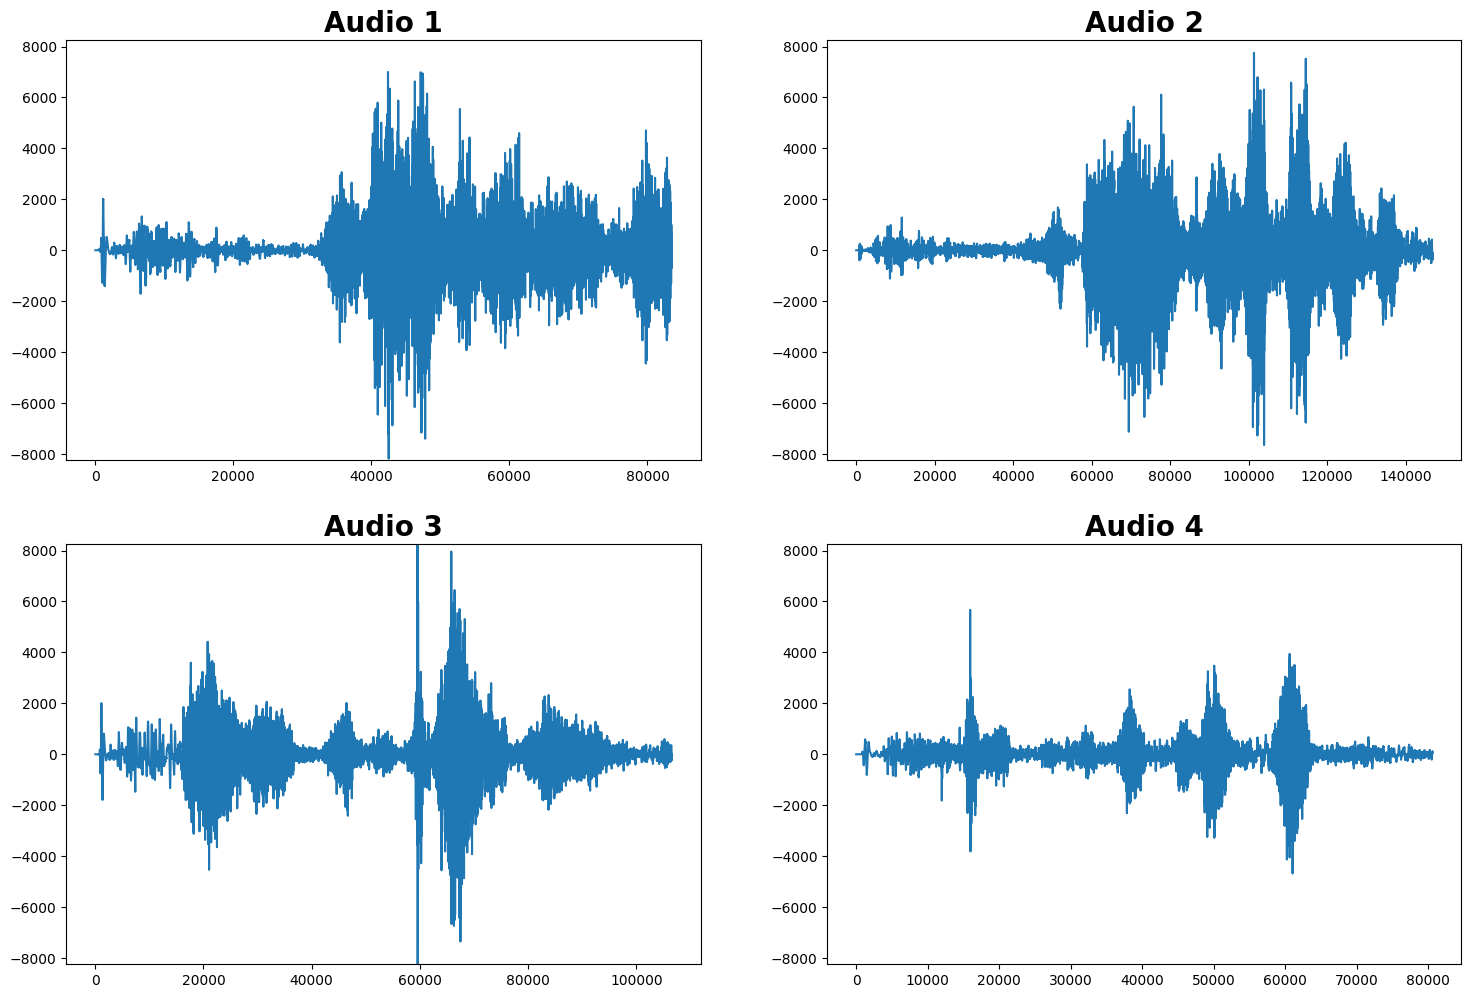

In [ ]:
# Plot the figure (axes - 10e-5)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = max(np.append(np.append(np.append(audio_1,audio_2),audio_3),audio_4))   # for y-axis range
ax1.plot(audio_1)
ax1.set_title("Audio 1", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_2)
ax2.set_title("Audio 2", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_3)
ax3.set_title("Audio 3", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_4)
ax4.set_title("Audio 4", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)

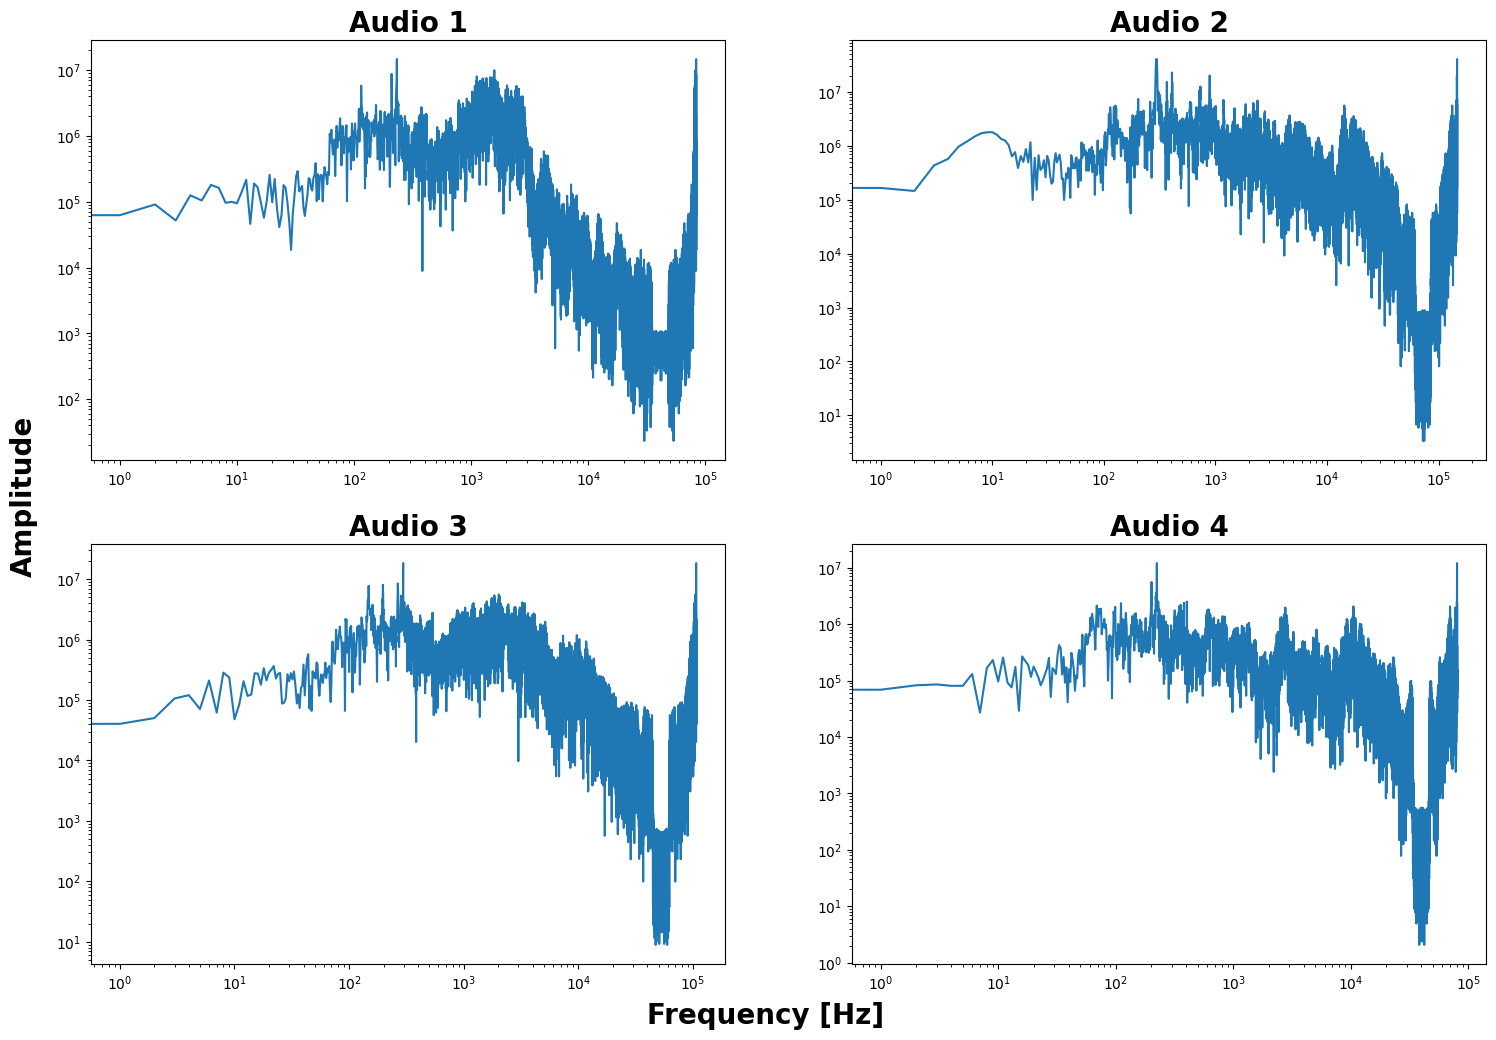

In [ ]:
# compute the FFT and take the single-sided spectrum only - computes magnitude of complex number
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ft_audio_1 = np.abs(2*np.fft.fft(audio_1))        # numpy.abs() gives magnitude of a complex number
ft_audio_2 = np.abs(2*np.fft.fft(audio_2))
ft_audio_3 = np.abs(2*np.fft.fft(audio_3))
ft_audio_4 = np.abs(2*np.fft.fft(audio_4))

# Plot the figure
ax1.plot(ft_audio_1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Audio 1", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Audio 2", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("Audio 3", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_4)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("Audio 4", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

### **[B] Load in default audio samples**
Instead of recording your own audio samples, you can load in some default ones.

We download a pickle file from github that contains the default audio samples using the [wget](https://www.gnu.org/software/wget/) command. **Wait for the file to sync in the Colab and then run the next cell!**

In [ ]:
!wget --no-check-certificate --content-disposition https://github.com/tinyMLx/colabs/blob/master/audio_files.pkl?raw=true
print("Wait a minute for the file to sync in the Colab and then run the next cell!")

--2024-04-11 03:38:10--  https://github.com/tinyMLx/colabs/blob/master/audio_files.pkl?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tinyMLx/colabs/raw/master/audio_files.pkl [following]
--2024-04-11 03:38:10--  https://github.com/tinyMLx/colabs/raw/master/audio_files.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tinyMLx/colabs/master/audio_files.pkl [following]
--2024-04-11 03:38:10--  https://raw.githubusercontent.com/tinyMLx/colabs/master/audio_files.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
fid = open('audio_files.pkl', 'rb')
audio_files = pickle.load(fid)                          # python dictionary
audio_yes_loud = audio_files['audio_yes_loud']
sr_yes_loud = audio_files['sr_yes_loud']
audio_yes_quiet = audio_files['audio_yes_quiet']
sr_yes_quiet = audio_files['sr_yes_quiet']
audio_no_loud = audio_files['audio_no_loud']
sr_no_loud = audio_files['sr_no_loud']
audio_no_quiet = audio_files['audio_no_quiet']
sr_no_quiet = audio_files['sr_no_quiet']

### Inspect audio sample

In [ ]:
print("audio_yes_loud:", audio_yes_loud)
print("type:", type(audio_yes_loud))
print("shape:", audio_yes_loud.shape)

audio_yes_loud: [  0   0   0 ... -10  -8  -4]
type: <class 'numpy.ndarray'>
shape: (83520,)


### Listen to Loaded Audio Samples
You can hear the audio files you just loaded below. IPython gives us a widget to play audio files through a notebook.

***Note*** - the loud yes and no audio could be too loud!

In [ ]:
Audio(audio_yes_loud, rate=sr_yes_loud)

In [ ]:
Audio(audio_yes_quiet, rate=sr_yes_quiet)

In [ ]:
Audio(audio_no_loud, rate=sr_no_loud)

In [ ]:
Audio(audio_no_quiet, rate=sr_no_quiet)

### Visualize the samples
[A] We will first visualize the audio samples as **signals**.

In [ ]:
# Plot the figure (axes - 10e-5)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = max(np.append(np.append(np.append(audio_yes_loud,audio_yes_quiet),audio_no_loud),audio_no_quiet))   # for y-axis range
ax1.plot(audio_yes_loud)
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_yes_quiet)
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_no_loud)
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_no_quiet)
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)


[B] Next, we will view the Fourier Transform of the signal i.e., the **signal in the frequency domain**. We will use `numpy.fft.fft()` for this. You can read more about the API [here](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html).



In [ ]:
# compute the FFT and take the single-sided spectrum only - computes magnitude of complex number
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ft_audio_yes_loud = np.abs(2*np.fft.fft(audio_yes_loud))        # numpy.abs() gives magnitude of a complex number
ft_audio_yes_quiet = np.abs(2*np.fft.fft(audio_yes_quiet))
ft_audio_no_loud = np.abs(2*np.fft.fft(audio_no_loud))
ft_audio_no_quiet = np.abs(2*np.fft.fft(audio_no_quiet))

# Plot the figure
ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

[C] Next, we will visualize the audio samples as spectrograms. We will be using `tfio.audio.spectrogram()` for this. You can read more about the API [here](https://www.tensorflow.org/io/api_docs/python/tfio/audio/spectrogram).

The implementation was adapted from -

Can you see how spectrograms can help machine learning models better differentiate between audio samples?

In [ ]:
# Convert to spectrogram and display
# adapted from https://aruno14.medium.com/comparaison-of-audio-representation-in-tensorflow-b6c33a83d77f
spectrogram_yes_loud = tfio.audio.spectrogram(audio_yes_loud/1.0, nfft=2048, window=len(audio_yes_loud), stride=int(sr_yes_loud * 0.008))
spectrogram_yes_quiet = tfio.audio.spectrogram(audio_yes_quiet/1.0, nfft=2048, window=len(audio_yes_quiet), stride=int(sr_yes_quiet * 0.008))
spectrogram_no_loud = tfio.audio.spectrogram(audio_no_loud/1.0, nfft=2048, window=len(audio_no_loud), stride=int(sr_no_loud * 0.008))
spectrogram_no_quiet = tfio.audio.spectrogram(audio_no_quiet/1.0, nfft=2048, window=len(audio_no_quiet), stride=int(sr_no_quiet * 0.008))




# spectrogram 1
spectrogram_yes_loud = tf.math.log(spectrogram_yes_loud)
# spectrogram_yes_loud = spectrogram_yes_loud.eval(session=tf.compat.v1.Session())      # to work with TF 2.x
spectrogram_yes_loud = spectrogram_yes_loud.numpy()

# spectrogram 2
spectrogram_yes_quiet = tf.math.log(spectrogram_yes_quiet)
# spectrogram_yes_quiet = spectrogram_yes_quiet.eval(session=tf.compat.v1.Session())
spectrogram_yes_quiet = spectrogram_yes_quiet.numpy()

# spectrogram 3
spectrogram_no_loud = tf.math.log(spectrogram_no_loud)
# spectrogram_no_loud = spectrogram_no_loud.eval(session=tf.compat.v1.Session())
spectrogram_no_loud = spectrogram_no_loud.numpy()

# spectrogram 4
spectrogram_no_quiet = tf.math.log(spectrogram_no_quiet)
# spectrogram_no_quiet = spectrogram_no_quiet.eval(session=tf.compat.v1.Session())
spectrogram_no_quiet = spectrogram_no_quiet.numpy()


# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(spectrogram_yes_loud, aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.imshow(spectrogram_yes_quiet, aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.imshow(spectrogram_no_loud, aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.imshow(spectrogram_no_quiet, aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)

[D] Finally, we will visualize the audio samples as **MFCCs** thereby using the Mel Scale to better associate the features to human hearing! We use the librosa library to achieve this. You can read more about the APIs we use here - [Link1](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html), [Link2](https://librosa.org/doc/main/generated/librosa.power_to_db.html). This implementation was adapted from -


1.   https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0




In [ ]:
# Convert to MFCC using the Mel Scale

mfcc_yes_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_yes_loud), sr=sr_yes_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_yes_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_yes_quiet), sr=sr_yes_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_no_loud), sr=sr_no_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_no_quiet), sr=sr_no_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(mfcc_yes_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_yes_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_no_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_no_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)

# 2. Keyword Spotting Model
In this section we will see how well a default pre-trained model works for the Keyword Spotting application.

This notebook uses a pre-trained 20 kB model based on [Simple Audio Recognition](https://www.tensorflow.org/tutorials/audio/simple_audio) to recognize keywords! The model is derived from a [micro_speech](https://github.com/tensorflow/tensorflow/tree/v2.4.1/tensorflow/lite/micro/examples/micro_speech) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview)

### Import Libraries
We import the following libraries.



In [ ]:
#%tensorflow_version 1.x
import tensorflow as tf

!wget https://github.com/tensorflow/tensorflow/archive/v2.16.1.zip
!unzip v2.16.1.zip &> 0
!mv tensorflow-2.16.1/ tensorflow/          # git repo

--2024-04-11 03:38:51--  https://github.com/tensorflow/tensorflow/archive/v2.16.1.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tensorflow/tensorflow/zip/refs/tags/v2.16.1 [following]
--2024-04-11 03:38:51--  https://codeload.github.com/tensorflow/tensorflow/zip/refs/tags/v2.16.1
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95820375 (91M) [application/zip]
Saving to: ‘v2.16.1.zip’

v2.16.1.zip         100%[===================>]  91.38M  84.8MB/s    in 1.1s    

2024-04-11 03:38:52 (84.8 MB/s) - ‘v2.16.1.zip’ saved [95820375/95820375]



In [ ]:
import sys
# We add this path so we can import the speech processing modules.
sys.path.append("/content/tensorflow/tensorflow/examples/speech_commands")

import input_data
import models
import numpy as np
import pickle


We clone the TensorFlow Github Repository, which contains the relevant code required to run this tutorial. The repository can be found on the left tab under /tensorflow.

### Configure Defaults
In the below cell, we define the words we want to train our model on. We define a comma-delimited list of the words you want to train for. All the other words you do not select will be used to train an "unknown" label so that the model does not just recognize speech but your specific words. Audio data with no spoken words will be used to train a "silence" label.

In [ ]:
WANTED_WORDS = "yes,no"

# Print the configuration to confirm it
print("Spotting these words: %s" % WANTED_WORDS)

Spotting these words: yes,no


We will use the default configurations to use the pre-trained model. **DO NOT MODIFY** the following constants as they include filepaths used in this notebook and data that is shared during training and inference.

In [ ]:
# Calculate the percentage of 'silence' and 'unknown' training samples required
# to ensure that we have equal number of samples for each label.

number_of_labels = WANTED_WORDS.count(',') + 1                               # count() counts the number of commas (substr provided)
number_of_total_labels = number_of_labels + 2                                # for 'silence' and 'unknown' label
equal_percentage_of_training_samples = int(100.0/(number_of_total_labels))
SILENT_PERCENTAGE = equal_percentage_of_training_samples
UNKNOWN_PERCENTAGE = equal_percentage_of_training_samples


# Constants which are shared during training and inference
PREPROCESS = 'micro'
WINDOW_STRIDE = 20
MODEL_ARCHITECTURE = 'tiny_conv'


# Constants for training directories and filepaths
DATASET_DIR =  'dataset/'
LOGS_DIR = 'logs/'
TRAIN_DIR = 'train/' # for training checkpoints and other files.


# Constants for inference directories and filepaths
import os
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
MODEL_TF = os.path.join(MODELS_DIR, 'model.pb')
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
FLOAT_MODEL_TFLITE = os.path.join(MODELS_DIR, 'float_model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')
SAVED_MODEL = os.path.join(MODELS_DIR, 'saved_model')


# Constants for Quantization
QUANT_INPUT_MIN = 0.0
QUANT_INPUT_MAX = 26.0
QUANT_INPUT_RANGE = QUANT_INPUT_MAX - QUANT_INPUT_MIN


# Constants for audio process during Quantization and Evaluation
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
FEATURE_BIN_COUNT = 40
BACKGROUND_FREQUENCY = 0.8
BACKGROUND_VOLUME_RANGE = 0.1
TIME_SHIFT_MS = 100.0


# URL for the dataset and train/val/test split
DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10

### Loading the pre-trained model

These commands will download a pre-trained model checkpoint file (the output from training) that we can use to build a model. You can read more about saving model checkpoints and using it for subsequent model inference here - [Link1](https://www.tensorflow.org/tutorials/keras/save_and_load), [Link2](https://www.tensorflow.org/guide/checkpoint)

You should see a train/ folder on the left tab. It contains the checkpoint and metadata.  

In [ ]:
!curl -O "https://storage.googleapis.com/download.tensorflow.org/models/tflite/speech_micro_train_2020_05_10.tgz"
!tar xzf speech_micro_train_2020_05_10.tgz
TOTAL_STEPS = 15000  # used to identify which checkpoint file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  375k  100  375k    0     0  3374k      0 --:--:-- --:--:-- --:--:-- 3386k


### Generate a TensorFlow Model for Inference

Below, we combine relevant training results (graph, weights, etc) into a single file for inference. This process is known as **freezing** a model and the resulting model is known as a frozen model/graph, as it cannot be further re-trained after this process.

We run the freeze.py script to achieve this.

After running this cell, you should find the saved model under models/ in the left tab.

In [ ]:
!rm -rf {SAVED_MODEL}

!python tensorflow/tensorflow/examples/speech_commands/freeze.py \
--wanted_words=$WANTED_WORDS \
--window_stride_ms=$WINDOW_STRIDE \
--preprocess=$PREPROCESS \
--model_architecture=$MODEL_ARCHITECTURE \
--start_checkpoint=$TRAIN_DIR$MODEL_ARCHITECTURE'.ckpt-'{TOTAL_STEPS} \
--save_format=saved_model \
--output_file={SAVED_MODEL}

2024-04-11 03:40:30.316694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 03:40:30.316751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 03:40:30.318021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 03:40:31.332510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:tensorflow:Restoring parameters from train/tiny_conv.ckpt-15000
I0411 03:40:33.697685 138565198102528 saver.py:1413] Restoring parameters from train/tiny_conv.ckpt-15000
Instructions for updating:
This API was designed for TensorFlow v1

### Generate a TensorFlow Lite Model

We convert the frozen graph into a TensorFlow Lite model, which is fully quantized for use with embedded devices. The following cell will also print the model size, which should be under 20 kilobytes.



First, we download the dataset to use as a representative dataset for more thoughtful post training quantization. We define an Audio Processor based on defined model settings that handles loading, partitioning, and preparing audio training data.

To read more about the `models.prepare_model_settings()` method and `input_data.AudioProcessor()` method you can read the implementation in src files under path "/content/tensorflow/tensorflow/examples/speech_commands/models.py" and "/content/tensorflow/tensorflow/examples/speech_commands/input_data.py". These two python files can be found in the tab to the left.  

**Note: this cell may take some time to run as it is a relatively large file** (Took around ~15 minutes)

In [ ]:
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)

audio_processor = input_data.AudioProcessor(
    DATA_URL, DATASET_DIR,
    SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
    WANTED_WORDS.split(','), VALIDATION_PERCENTAGE,
    TESTING_PERCENTAGE, model_settings, LOGS_DIR)

>> Downloading speech_commands_v0.02.tar.gz 100.0%


We create float and quantized TFLite models below. We use Integer Quantization.

In [ ]:
#with tf.Session() as sess:                                           #replaces the below line for use with TF1.x
with tf.compat.v1.Session() as sess:

  # float model
  float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
  print()
  print("Float model is %d bytes" % float_tflite_model_size)

  # quantized model
  converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  #converter.inference_input_type = tf.lite.constants.INT8            #replaces the below line for use with TF1.x
  converter.inference_input_type = tf.compat.v1.lite.constants.INT8
  #converter.inference_output_type = tf.lite.constants.INT8           #replaces the below line for use with TF1.x
  converter.inference_output_type = tf.compat.v1.lite.constants.INT8

  def representative_dataset_gen():
    for i in range(100):
      data, _ = audio_processor.get_data(1, i*1, model_settings,
                                         BACKGROUND_FREQUENCY,
                                         BACKGROUND_VOLUME_RANGE,
                                         TIME_SHIFT_MS,
                                         'testing',
                                         sess)
      flattened_data = np.array(data.flatten(), dtype=np.float32).reshape(1, 1960)
      yield [flattened_data]

  converter.representative_dataset = representative_dataset_gen
  tflite_model = converter.convert()
  tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
  print("Quantized model is %d bytes" % tflite_model_size)


Instructions for updating:
Use `tf.saved_model.load` instead.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.



Float model is 68356 bytes
Quantized model is 18960 bytes


---


**Question 1**: What does audio_processor.get_data() do? Refer to input_data.py

**Answer:**



---

### Testing the accuracy after Quantization

In the below cell, we run inference of our model on the entire test dataset.

In [ ]:
# Helper function to run inference
def run_tflite_inference_testSet(tflite_model_path, model_type="Float"):

  # extract test data
  np.random.seed(0) # set random seed for reproducible test results.
  #with tf.Session() as sess:                                                 #replaces the below line for use with TF1.x
  with tf.compat.v1.Session() as sess:
    test_data, test_labels = audio_processor.get_data(
        -1, 0, model_settings, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'testing', sess)
  test_data = np.expand_dims(test_data, axis=1).astype(np.float32)



  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(tflite_model_path)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  # For quantized models, manually quantize the input data from float to integer
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])


  # Evaluate the predictions
  correct_predictions = 0
  for i in range(len(test_data)):
    interpreter.set_tensor(input_details["index"], test_data[i])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == test_labels[i])


  print('%s model accuracy is %f%% (Number of test samples=%d)' % (
      model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

In [ ]:
# Compute float model accuracy
run_tflite_inference_testSet(FLOAT_MODEL_TFLITE)

# Compute quantized model accuracy
run_tflite_inference_testSet(MODEL_TFLITE, model_type='Quantized')

Float model accuracy is 91.666667% (Number of test samples=1236)
Quantized model accuracy is 91.666667% (Number of test samples=1236)


# 3. Testing the model on example Audio
Now that we know the model is fairly accurate on the test set lets explore with some hand crafted examples just how accurate the model is in the real world!

### Load example audio samples

Here, we download and load the 'yes_no.pkl' file that contains a few example audio samples for 'yes' and 'no'.

In [ ]:
from IPython.display import HTML, Audio
!wget --no-check-certificate --content-disposition https://github.com/tinyMLx/colabs/blob/master/yes_no.pkl?raw=true
print("Wait a minute for the file to sync in the Colab and then run the next cell!")

--2024-04-11 04:02:37--  https://github.com/tinyMLx/colabs/blob/master/yes_no.pkl?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tinyMLx/colabs/raw/master/yes_no.pkl [following]
--2024-04-11 04:02:37--  https://github.com/tinyMLx/colabs/raw/master/yes_no.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tinyMLx/colabs/master/yes_no.pkl [following]
--2024-04-11 04:02:37--  https://raw.githubusercontent.com/tinyMLx/colabs/master/yes_no.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1567396 (1.5M) [applic

In [ ]:
fid = open('yes_no.pkl', 'rb')
audio_files = pickle.load(fid)
yes1 = audio_files['yes1']
yes2 = audio_files['yes2']
yes3 = audio_files['yes3']
yes4 = audio_files['yes4']
no1 = audio_files['no1']
no2 = audio_files['no2']
no3 = audio_files['no3']
no4 = audio_files['no4']
sr_yes1 = audio_files['sr_yes1']
sr_yes2 = audio_files['sr_yes2']
sr_yes3 = audio_files['sr_yes3']
sr_yes4 = audio_files['sr_yes4']
sr_no1 = audio_files['sr_no1']
sr_no2 = audio_files['sr_no2']
sr_no3 = audio_files['sr_no3']
sr_no4 = audio_files['sr_no4']

In [ ]:
Audio(yes1, rate=sr_yes1)

In [ ]:
Audio(yes2, rate=sr_yes2)

In [ ]:
Audio(yes3, rate=sr_yes3)

In [ ]:
Audio(yes4, rate=sr_yes4)

In [ ]:
Audio(no1, rate=sr_no1)

In [ ]:
Audio(no2, rate=sr_no2)

In [ ]:
Audio(no3, rate=sr_no3)

In [ ]:
Audio(no4, rate=sr_no4)

### Test the model on the Example Files
We first need to import a series of packages and build the loudest section tool so that we can process audio files manually to send them to our model. These packages will also be used later for you to record your own audio to test the model!

In [ ]:
!pip install ffmpeg-python &> 0
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import librosa
import scipy.io.wavfile

In [ ]:
!git clone https://github.com/petewarden/extract_loudest_section.git
!make -C extract_loudest_section/
print("Packages Imported, Extract_Loudest_Section Built")

Cloning into 'extract_loudest_section'...
remote: Enumerating objects: 58, done.
remote: Total 58 (delta 0), reused 0 (delta 0), pack-reused 58
Receiving objects: 100% (58/58), 49.00 KiB | 3.06 MiB/s, done.
Resolving deltas: 100% (17/17), done.
make: Entering directory '/content/extract_loudest_section'
gcc --std=c++11 -O3 -DNDEBUG -I. -c main.cc -o /tmp/extract_loudest_section//gen/obj/./main.o
gcc --std=c++11 -O3 -DNDEBUG -I. -c status.cc -o /tmp/extract_loudest_section//gen/obj/./status.o
gcc --std=c++11 -O3 -DNDEBUG -I. -c wav_io.cc -o /tmp/extract_loudest_section//gen/obj/./wav_io.o
gcc  -I. \
-o /tmp/extract_loudest_section//gen/bin//extract_loudest_section /tmp/extract_loudest_section//gen/obj/./main.o /tmp/extract_loudest_section//gen/obj/./status.o /tmp/extract_loudest_section//gen/obj/./wav_io.o \
 -lstdc++ -lm
make: Leaving directory '/content/extract_loudest_section'
Packages Imported, Extract_Loudest_Section Built


In [ ]:
# Helper function to run inference (on a single input this time)
# Note: this also includes additional manual pre-processing

TF_SESS = tf.compat.v1.InteractiveSession()
def run_tflite_inference_singleFile(tflite_model_path, custom_audio, sr_custom_audio, model_type="Float"):

  # Preprocess the sample to get the features we pass to the model
  # First re-sample to the needed rate (and convert to mono if needed)
  custom_audio_resampled = librosa.resample(y=librosa.to_mono(np.float64(custom_audio)),
                                            orig_sr=sr_custom_audio, target_sr=SAMPLE_RATE)
  # Then extract the loudest one second
  scipy.io.wavfile.write('custom_audio.wav', SAMPLE_RATE, np.int16(custom_audio_resampled))
  !/tmp/extract_loudest_section/gen/bin/extract_loudest_section custom_audio.wav ./trimmed
  # Finally pass it through the TFLiteMicro preprocessor to produce the
  # spectrogram/MFCC input that the model expects
  custom_model_settings = models.prepare_model_settings(
      0, SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
      WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
  custom_audio_processor = input_data.AudioProcessor(None, None, 0, 0, '', 0, 0,
                                                    model_settings, None)
  custom_audio_preprocessed = custom_audio_processor.get_features_for_wav(
                                        'trimmed/custom_audio.wav', model_settings, TF_SESS)

  # Reshape the output into a 1,1960 matrix as that is what the model expects
  custom_audio_input = custom_audio_preprocessed[0].flatten()
  test_data = np.reshape(custom_audio_input,(1,len(custom_audio_input)))


  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(tflite_model_path)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  # For quantized models, manually quantize the input data from float to integer
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])


  # Run the interpreter
  interpreter.set_tensor(input_details["index"], test_data)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]
  top_prediction = output.argmax()


  # Translate the output
  top_prediction_str = ''
  if top_prediction == 2 or top_prediction == 3:
    top_prediction_str = WANTED_WORDS.split(',')[top_prediction-2]
  elif top_prediction == 0:
    top_prediction_str = 'silence'
  else:
    top_prediction_str = 'unknown'

  print('%s model guessed the value to be %s' % (model_type, top_prediction_str))

In [ ]:
# Then test the model -- do they all work as you'd expect?
print("Testing yes1")
run_tflite_inference_singleFile(MODEL_TFLITE, yes1, sr_yes1, model_type="Quantized")
print("Testing yes2")
run_tflite_inference_singleFile(MODEL_TFLITE, yes2, sr_yes2, model_type="Quantized")
print("Testing yes3")
run_tflite_inference_singleFile(MODEL_TFLITE, yes3, sr_yes3, model_type="Quantized")
print("Testing yes4")
run_tflite_inference_singleFile(MODEL_TFLITE, yes4, sr_yes4, model_type="Quantized")
print("Testing no1")
run_tflite_inference_singleFile(MODEL_TFLITE, no1, sr_no1, model_type="Quantized")
print("Testing no2")
run_tflite_inference_singleFile(MODEL_TFLITE, no2, sr_no2, model_type="Quantized")
print("Testing no3")
run_tflite_inference_singleFile(MODEL_TFLITE, no3, sr_no3, model_type="Quantized")
print("Testing no4")
run_tflite_inference_singleFile(MODEL_TFLITE, no4, sr_no4, model_type="Quantized")

Testing yes1
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be yes
Testing yes2
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be no
Testing yes3
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be unknown
Testing yes4
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be yes
Testing no1
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be no
Testing no2
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be unknown
Testing no3
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be unknown
Testing no4
Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be no


## Testing the model with your own data!

Try recording your own audio to test the model. You can experiment with different ways to say 'yes' and 'no'. Also, test the 'unknown' and 'silence' classes.

### Define the audio importing function
Adapted from: https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/ and https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=RtMcXr3o6gxN

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    bitsPerSecond: 128000, //chrome seems to ignore, always 48k
    audioBitsPerSecond: 128000, //chrome seems to ignore, always 48k
    mimeType : 'audio/mp4'
    // mimeType : 'audio/webm;codecs=opus' // try me if the above fails
  };
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav', ac='1')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr
print("Chrome Audio Recorder Defined")

Chrome Audio Recorder Defined


### Record your own audio and test the model!
After you run the record cell wait for the stop button to appear then start recording and then press the button to stop the recording once you have said the word!

In [ ]:
custom_audio, sr_custom_audio = get_audio()
print("DONE")

DONE


In [ ]:
# Then test the model
run_tflite_inference_singleFile(MODEL_TFLITE, custom_audio, sr_custom_audio, model_type="Quantized")

Saved to './trimmed/custom_audio.wav'
Quantized model guessed the value to be no


# Hardware component

### Load the pretrained Tensorflow Lite model
Upload the pretrained TFlite file to the folders section on the left pane.

### Generate a TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [ ]:
!apt-get update && apt-get -qq install xxd

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,691 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,081 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main 

In [ ]:
MODEL_TFLITE = '/content/models/model.tflite' #enter the name of your TFlite file uploaded to the folders section
MODEL_TFLITE_MICRO = 'kws.cc' #update the name of your .cc file (This can be anything)
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE! **So don't close this Colab as we'll use the model printout in the next step of the deployment to the Arduino IDE!**

In [ ]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00,
  0xcc, 0x42, 0x00, 0x00, 0xdc, 0x42, 0x00, 0x00, 0x70, 0x49, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x34, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xdc, 0xff, 0xff, 0xff,
  0x0e, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00,
  0x43, 0x4f, 0x4e, 0x56, 0x45, 0x52, 0x53, 0x49, 0x4f, 0x4e, 0x5f, 0x4d,
  0x45, 0x54, 0x41, 0x44, 0x41, 0x54, 0x41, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x08, 0x00, 0x00, 0x00, 0x0d, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x

If you'd like to download your model for safekeeping:
1. On the left of the UI click on the folder icon
2. Click on the three dots to the right of the ```kws.cc``` file and select download